# 1- Importing Required Modules & Root Path

In [13]:
import tensorflow as tf
import keras.layers as tfl
import os
import matplotlib.pyplot as plt
import csv
from PIL import Image

In [14]:
path_root = "C:/Users/Deniz/CODEWORKS/remote-sensing-scene-classification-for-aerial-imaging/"

# 2- Importing the Dataset

## 2.1- Getting Filenames Dataset

1) Defining dataset path

In [15]:
path_dataset = path_root + "datasets/MLRSNet/Images"

2) Creating list dataset that contains file names with full path by using dataset root path

In [16]:
list_dataset = tf.data.Dataset.list_files(str(path_dataset+"/*/*"), shuffle=True)

# Examples
for ex in list_dataset.take(5):

    # Print modified-for-readiblity version of samples 
    print(ex.numpy().split(b"/")[-4:])

[b'C:\\Users\\Deniz\\CODEWORKS\\remote-sensing-scene-classification-for-aerial-imaging\\datasets\\MLRSNet\\Images\\transmission_tower\\transmission_tower_00752.jpg']
[b'C:\\Users\\Deniz\\CODEWORKS\\remote-sensing-scene-classification-for-aerial-imaging\\datasets\\MLRSNet\\Images\\island\\island_01314.jpg']
[b'C:\\Users\\Deniz\\CODEWORKS\\remote-sensing-scene-classification-for-aerial-imaging\\datasets\\MLRSNet\\Images\\storage_tank\\storage_tank_00877.jpg']
[b'C:\\Users\\Deniz\\CODEWORKS\\remote-sensing-scene-classification-for-aerial-imaging\\datasets\\MLRSNet\\Images\\intersection\\intersection_01498.jpg']
[b'C:\\Users\\Deniz\\CODEWORKS\\remote-sensing-scene-classification-for-aerial-imaging\\datasets\\MLRSNet\\Images\\golf_course\\golf_course_02919.jpg']


In [17]:
list_dataset.element_spec

TensorSpec(shape=(), dtype=tf.string, name=None)

## 2.2- Getting Image Dataset

1) Mapping "convert path to image" operation in order to get image dataset 

In [18]:
def convert_path_to_image(name_path):

    # Path-to-image conversion and image decoding
    path_parts = tf.strings.split(name_path, os.sep)
    # Get label from root file of image 
    label = path_parts[-2]
    # Read image from given path
    image = tf.io.read_file(name_path)
    # Decode image as JPEG
    image = tf.io.decode_jpeg(image, channels=3)
    
    # Return image and label
    return image, label

2) Applying the mapping to dataset

In [19]:
image_dataset = list_dataset.map(convert_path_to_image)

In [20]:
image_dataset.element_spec

(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None),
 TensorSpec(shape=(), dtype=tf.string, name=None))

3. Testing mapping by sampling image dataset

In [21]:
def mapping_test(dataset, num=3, one_hot_label=False, classes=None):

    # Defining the subplot
    fig, axes = plt.subplots(1,num, figsize=(12,6))
    print(dataset.element_spec)
    
    for i, (image,label) in enumerate(dataset.take(num)):
        # Showing the  sample image 
        axes[i].imshow(image)
        # one_hot_label condition
        if not one_hot_label:
            # If the label is not one-hot-encoded
            label = label.numpy().decode("utf-8")
        else:
            # If the label is one-hot-encoded
            print("One-Hot label:", label)
            label_ind = tf.argmax(label).numpy()
            label = classes[label_ind] 
        # Showing the label as title
        axes[i].set_title(label)
        
    # Showing the plot 
    plt.show()

(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))


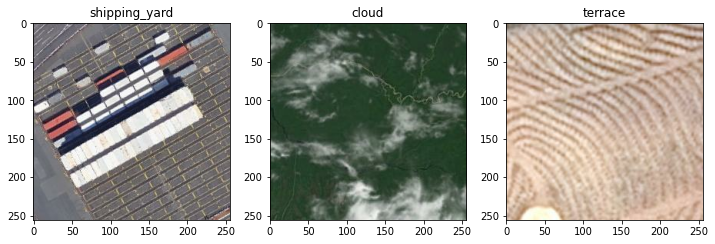

In [22]:
mapping_test(image_dataset)

## 2.3- Preprocessing Image Dataset

1) Loading class names as a list by using "class_names.csv" file

In [23]:
classes_list = []
path_classes_list_file = path_root +"datasets/MLRSNet/class_names.csv"

with open(path_classes_list_file, "r", ) as my_file:
    new_content = csv.reader(my_file)
    for row in new_content:
        classes_list.append(row[0])

In [24]:
print(classes_list)
print("number of classes:", len(classes_list))

['airplane', 'airport', 'bareland', 'baseball_diamond', 'basketball_court', 'beach', 'bridge', 'chaparral', 'cloud', 'commercial_area', 'dense_residential_area', 'desert', 'eroded_farmland', 'farmland', 'forest', 'freeway', 'golf_course', 'ground_track_field', 'harbor&port', 'industrial_area', 'intersection', 'island', 'lake', 'meadow', 'mobile_home_park', 'mountain', 'overpass', 'park', 'parking_lot', 'parkway', 'railway', 'railway_station', 'river', 'roundabout', 'shipping_yard', 'snowberg', 'sparse_residential_area', 'stadium', 'storage_tank', 'swimmimg_pool', 'tennis_court', 'terrace', 'transmission_tower', 'vegetable_greenhouse', 'wetland', 'wind_turbine']
number of classes: 46


2) Defining one_hot_encoder function which takes "image" and "label" of each element and, outputs "image" "one hot encoded label"

In [25]:
def one_hot_encoder(image, label, classes):

    # Get the boolean match of the label
    tensor_classes_bool = tf.constant(classes) == label
    # Cast the boolean result as a tf.float32 tensor
    label_one_hot = tf.cast(tensor_classes_bool, dtype=tf.float32)

    # Return to replace
    return (image, label_one_hot)

3) Applying the transformation

In [26]:
image_dataset = image_dataset.map(lambda image,label: one_hot_encoder(image, label, classes_list))

In [27]:
image_dataset.element_spec

(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None),
 TensorSpec(shape=(46,), dtype=tf.float32, name=None))

### 2.3.2- Applying Data Augmentation

1) Apply resize, cropping, horizontal flipping, brightnes and contrast changing randomly

In [28]:
def apply_data_augmentation(image, label, seed=(5,0), size=[224, 224, 3], max_delta=0.3, lower=0.3, upper=1.7):

    # Get random dimension
    random_size = tf.cast(tf.random.uniform([], minval=256, maxval=481, dtype=tf.int32), dtype=tf.float32)
    # Apply random resizing to use random cropping
    image = tf.image.resize(image, [random_size, random_size])
    # Apply random horizontal flip
    image = tf.image.stateless_random_flip_left_right(image, seed)
    # Apply random cropping to resized image
    image = tf.image.stateless_random_crop(image, size, seed)
    # Apply random brightness changing
    image = tf.image.stateless_random_brightness(image, max_delta, seed)
    # Apply random contrast changing
    image = tf.image.stateless_random_contrast(image, lower, upper, seed)

    # Return image and label
    return image, label

2. Defining random number generator wrapper

In [29]:
rng = tf.random.Generator.from_seed(21, alg='philox')

In [30]:
def rng_wrapper_for_data_augmentation(image, label, rng_object):

    # create new seed by using rng object
    current_seed = rng_object.make_seeds(2)[0]
    # apply data augmentation to current image with newly created seed
    image, label = apply_data_augmentation(image, label, current_seed)

    # return augmentation-applied image and label
    return image, label

3) Apply the transformation

In [31]:
image_dataset = image_dataset.map(lambda image,label: rng_wrapper_for_data_augmentation(image, label, rng))

In [32]:
image_dataset.element_spec

(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(46,), dtype=tf.float32, name=None))

### 2.3.3- Scaling Image Dataset

1) Definign rescaler function that rescales each image element to between 0-1

In [33]:
def rescaler(image,label):

    # Apply scaling (normalization from statistic convension) to range between 0-1 
    image = tfl.Rescaling(scale=1./255) (image)

    # Return image and label
    return image,label

2) Apply the transformation

In [34]:
image_dataset = image_dataset.map(rescaler)

(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(46,), dtype=tf.float32, name=None))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


One-Hot label: tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(46,), dtype=float32)
One-Hot label: tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(46,), dtype=float32)
One-Hot label: tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(46,), dtype=float32)


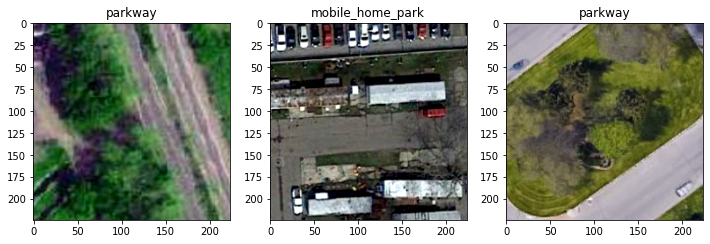

In [35]:
mapping_test(image_dataset, one_hot_label=True, classes=classes_list)

## 2.4- Configuring Image Dataset

1) Splitting training and test sets

In [36]:
def split_dataset(dataset, train_set_ratio, test_set_ratio, val_set_ratio=0):
    
    # Get the dataset length
    len_dataset = len(image_dataset)

    # Check if the ratio is correct
    if train_set_ratio + val_set_ratio + test_set_ratio != 1:
        raise ValueError("Incorrect split ratio")

    # Calculate the indices
    train_size = int(len_dataset * train_set_ratio)
    remaining_size = int(len_dataset - train_size)

    # If the val_set is intended
    if val_set_ratio != 0:
        val_set_ratio_remaining = float(val_set_ratio / (val_set_ratio + test_set_ratio))
        #print("val_set_ratio_remaining", val_set_ratio_remaining)
        val_size = int(remaining_size *  val_set_ratio_remaining)
        val_index = train_size + val_size
        test_size = remaining_size - val_size

    else:
        test_size = remaining_size

    # Write the sizes
    print("train size:",train_size)
    print("test size:", test_size)
    if val_set_ratio != 0: 
        print("val size:", val_size)

    # Split the dataset
    dataset_train = dataset.take(train_size)
    dataset_remaining = dataset.skip(train_size)

    if val_set_ratio != 0:
        dataset_val = dataset_remaining.take(val_size)
        dataset_test = dataset_remaining.skip(val_size)
         
        return dataset_train, dataset_test, dataset_val
        
    else:
        dataset_test = dataset_remaining
        return dataset_train, dataset_remaining


In [41]:
dataset_train, dataset_test, dataset_val = split_dataset(image_dataset, 0.8, 0.1, 0.1)

train size: 87328
test size: 10917
val size: 10916


2) Configuring mini batches

In [42]:
dataset_train = dataset_train.shuffle(buffer_size=1024, reshuffle_each_iteration=True).batch(16, drop_remainder=True)
dataset_val = dataset_val.shuffle(buffer_size=1024, reshuffle_each_iteration=True).batch(16, drop_remainder=True)
dataset_test = dataset_test.shuffle(buffer_size=1024, reshuffle_each_iteration=True).batch(16, drop_remainder=True)

In [43]:
del dataset_train
del dataset_val

# 3- Building Model

1) Defining the ResNet50 "identity shortcut block" function

In [30]:
def identity_block(block_input, filters, stage="n", block="m"):
    """
    Identity shortcut block implementation with bottleneck design from ResNet-50 architecture.
    """

    # Define the block name with stage prefix
    block_name = f"iden_block_{str(stage)}_{str(block)}"
    bn_name = f"iden_bn_{str(stage)}_{str(block)}"

    # Unpack the filters input
    f1, f2, f3 = filters

    # Define the destructing step of bottleneck design, apply BatchNorm and ReLU
    block_destruct = tfl.Conv2D(filters=f1, kernel_size=(1,1), strides=(1,1), padding="valid", kernel_initializer="he_normal", name=block_name+ "_d") (block_input)
    block_destruct = tfl.BatchNormalization(name=bn_name+"_d") (block_destruct)
    block_destruct = tfl.Activation("relu") (block_destruct)

    # Define the feature extractor step of bottleneck design, apply BatchNorm and ReLU
    block_neck = tfl.Conv2D(filters=f2, kernel_size=(3,3), strides=(1,1),  padding="same", kernel_initializer="he_normal", name=block_name+ "_n") (block_destruct)
    block_neck = tfl.BatchNormalization(name=bn_name+"_n") (block_neck)
    block_neck = tfl.Activation("relu") (block_neck)

    # Define the restoring step of bottleneck design, apply BatchNorm and ReLU
    block_restore = tfl.Conv2D(filters=f3, kernel_size=(1,1), strides=(1,1), padding="valid", kernel_initializer="he_normal", name=block_name+ "_r") (block_neck)
    block_restore = tfl.BatchNormalization(name=bn_name+"_r") (block_restore)
    
    # Define shortcut connection
    shortcut = block_input

    # Define the residual block output and apply ReLU
    block_restore = tfl.Add() ([block_restore, shortcut])
    block_output = tfl.Activation("relu") (block_restore)

    # Return the residual block output
    return block_output

2) Defining the ResNet50 "projection shortcut block" function

In [31]:
def projection_block(block_input, filters, strides=(2,2), stage="n", block="m"):
    """
    Projection (convolutional) shortcut block implementation with bottleneck design from ResNet-50 architecture.
    """
    
    # Define the block name with stage prefix
    block_name = f"proj_block_{str(stage)}_{str(block)}_"
    bn_name = f"proj_bn_{str(stage)}_{str(block)}_"

    # Unpack the filters input
    f1, f2, f3 = filters

    # Define the destructing step of bottleneck design, apply BatchNorm and ReLU
    block_destruct = tfl.Conv2D(filters=f1, kernel_size=(1,1), strides=strides, padding="valid", kernel_initializer="he_normal", name=block_name+ "d") (block_input)
    block_destruct = tfl.BatchNormalization(name=bn_name+"d") (block_destruct)
    block_destruct = tfl.Activation("relu", name=block_name+"act"+"_d") (block_destruct)

    # Define the feature extractor step of bottleneck design, apply BatchNorm and ReLU
    block_neck = tfl.Conv2D(filters=f2, kernel_size=(3,3), strides=(1,1),  padding="same", kernel_initializer="he_normal", name=block_name+ "n") (block_destruct)
    block_neck = tfl.BatchNormalization(name=bn_name+"n") (block_neck)
    block_neck = tfl.Activation("relu", name=block_name+"act"+"_n") (block_neck)

    # Define the restoring step of bottleneck design, apply BatchNorm and ReLU
    block_restore = tfl.Conv2D(filters=f3, kernel_size=(1,1), strides=(1,1), padding="valid", kernel_initializer="he_normal", name=block_name+ "r") (block_neck)
    block_restore = tfl.BatchNormalization(name=bn_name+"r") (block_restore)

    # Define shortcut connection
    shortcut = tfl.Conv2D(filters=f3, kernel_size=(1,1), strides=strides, padding="valid", name=block_name+"sc") (block_input)
    shortcut = tfl.BatchNormalization() (shortcut)

    # Define the residual block output and apply ReLU
    block_restore = tfl.Add() ([block_restore, shortcut])
    block_output = tfl.Activation("relu", name=block_name+"act"+"_o") (block_restore)

    # Return the residual block output
    return block_output

3) Defining the ResNet50 "initial block" function

In [32]:
def initial_block(input_layer, filters=64, stage="1", block="1"):
    """
    Initializer block of ResNet architecture that applies zero-padding, conv2d and max-pooling respectively. 
    """

    # Define the block name
    block_name = f"initial_{str(stage)}_{str(block)}_"

    # Apply initial zero-padding to preserve dims.
    block_init = tfl.ZeroPadding2D(padding=(3,3)) (input_layer)

    # Define the initial conv. block, apply BatchNorm and ReLU
    block_init = tfl.Conv2D(filters=filters, kernel_size=(7,7), strides=(2,2), padding="valid", kernel_initializer="he_normal", name=block_name+"conv") (block_init)
    block_init = tfl.BatchNormalization(name=block_name + "bn") (block_init) 
    block_init = tfl.Activation("relu") (block_init)

    # Apply max-pooling
    block_init = tfl.MaxPool2D(pool_size=(3,3), strides=(2,2)) (block_init)

    # Return initial block output
    return block_init

4) Defining the ResNet50 model architecture function

In [33]:
def ResNet50(input_shape=(224,224,3), output_classes_shape=10):

    # Define the input layer object
    layer_input = tf.keras.Input(input_shape)

    # STAGE-1: INIT
    block_init = initial_block(layer_input)

    # STAGE-2: 3x Residual Block
    stage2 = projection_block(block_init, (64,64,256), strides=(1,1), stage=2, block=1)
    stage2 = identity_block(stage2, (64,64,256), stage=2, block=2)
    stage2 = identity_block(stage2, (64,64,256), stage=2, block=3)

    # STAGE-3: 4x Residual Block
    stage3 = projection_block(stage2, (128,128,512), stage=3, block=1)
    stage3 = identity_block(stage3, (128,128,512), stage=3, block=2)
    stage3 = identity_block(stage3, (128,128,512), stage=3, block=3)
    stage3 = identity_block(stage3, (128,128,512), stage=3, block=4)

    # STAGE-4: 6x Residual Block
    stage4 = projection_block(stage3, (256,256,1024), stage=4, block=1)
    stage4 = identity_block(stage4, (256,256,1024), stage=4, block=2)
    stage4 = identity_block(stage4, (256,256,1024), stage=4, block=3)
    stage4 = identity_block(stage4, (256,256,1024), stage=4, block=4)
    stage4 = identity_block(stage4, (256,256,1024), stage=4, block=5)
    stage4 = identity_block(stage4, (256,256,1024), stage=4, block=6)

    # STAGE-5: 3x Residual Block
    stage5 = projection_block(stage4, (512,512,2048), stage=5, block=1)
    stage5 = identity_block(stage5, (512,512,2048), stage=5, block=2)
    stage5 = identity_block(stage5, (512,512,2048), stage=5, block=3)

    # OUTRO
    stage6 = tfl.AveragePooling2D(pool_size=(7,7)) (stage5)
    stage6 = tfl.Flatten() (stage6)
    layer_output = tfl.Dense(units=output_classes_shape, activation="softmax") (stage6)

    # Definition of model object
    model = tf.keras.Model(inputs=layer_input, outputs=layer_output)

    # Return the model object
    return model


5) Creating a CNN model

In [34]:
# Defining input shape
input_shape = tuple([int(i) for i in image_dataset.element_spec[0].shape.__repr__()[-13:-2].split(", ")])
print("Input shape:",input_shape)

Input shape: (224, 224, 3)


In [35]:
# Defining output shape
output_classes_shape = len(classes_list)
print("Output shape:", output_classes_shape)

Output shape: 46


In [36]:
resnet50Model = ResNet50(input_shape, output_classes_shape)

6) Compiling the model

In [37]:
resnet50Model.compile(optimizer= tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9),
                    loss= tf.keras.losses.CategoricalCrossentropy(),
                    metrics=["accuracy"])

7) Printing the model architecture summary

In [38]:
resnet50Model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 initial_1_1_conv (Conv2D)      (None, 112, 112, 64  9472        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

# 4- Training Model

In [30]:
# Define the checkpoint path
path_checkpoint = path_root + "checkpoints/resnet50_model_{epoch:02d}-{val_accuracy:.2f}"

# Define the ModelCheckpoint callback
callback_model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=path_checkpoint,
    save_weights_only=False,
    monitor="val_accuracy",
    save_freq="epoch" )

# Define the EarlyStopping callback
callback_early_stopping  = tf.keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=3)

In [40]:
history = resnet50Model.fit(
    x=dataset_train,
    epochs=10,
    validation_data=dataset_val,
    callbacks=[
        callback_model_checkpoint,
        callback_early_stopping
        ],
    )

Epoch 1/10
5458/5458 [==============================] - 2120s 386ms/step - loss: 2.8814 - accuracy: 0.2442 - val_loss: 2.4915 - val_accuracy: 0.3804
Epoch 2/10
5458/5458 [==============================] - 2098s 383ms/step - loss: 2.1004 - accuracy: 0.4170 - val_loss: 2.8711 - val_accuracy: 0.3648
Epoch 3/10
5458/5458 [==============================] - 2081s 380ms/step - loss: 1.6813 - accuracy: 0.5256 - val_loss: 2.7661 - val_accuracy: 0.5634
Epoch 4/10
5458/5458 [==============================] - 2002s 366ms/step - loss: 1.3788 - accuracy: 0.6057 - val_loss: 2.2055 - val_accuracy: 0.6047
Epoch 5/10
5458/5458 [==============================] - 2377s 435ms/step - loss: 1.1831 - accuracy: 0.6596 - val_loss: 3.2418 - val_accuracy: 0.5587
Epoch 6/10
5458/5458 [==============================] - 1985s 363ms/step - loss: 1.0428 - accuracy: 0.6972 - val_loss: 9.4072 - val_accuracy: 0.5947
Epoch 7/10
5458/5458 [==============================] - 2704s 495ms/step - loss: 0.9496 - accuracy: 0.7245

In [41]:
history_loss = history.history["loss"]
history_accuracy = history.history["accuracy"]
history_val_loss = history.history["val_loss"]
history_val_accuracy = history.history["val_accuracy"]

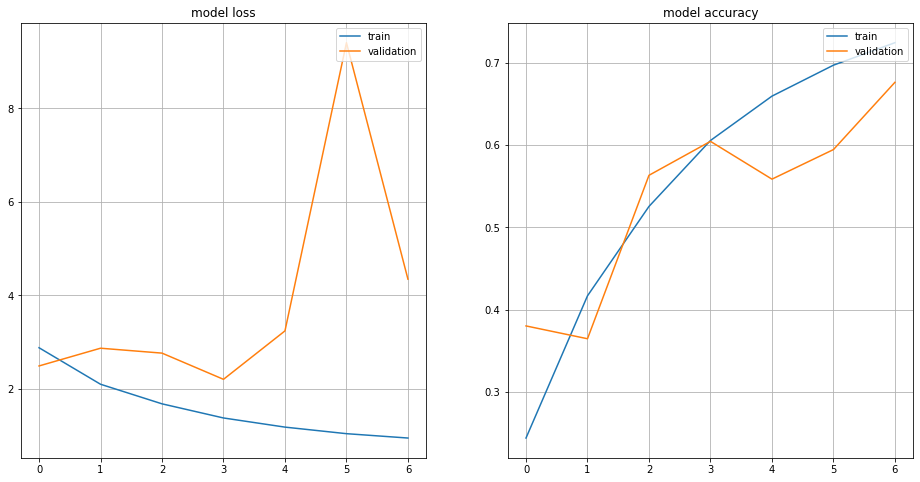

In [42]:
fig1, (ax11, ax12)  = plt.subplots(1, 2, figsize=(16,8))
ax11.plot(history_loss, label="train")
ax11.plot(history_val_loss, label="validation")
ax11.set_title("model loss")
ax11.legend(loc="upper right")
ax11.grid()

ax12.plot(history_accuracy, label="train")
ax12.plot(history_val_accuracy, label="validation")
ax12.set_title("model accuracy")
ax12.legend(loc="upper right")
ax12.grid()

In [31]:
# define latest epoch path
model_path = path_root +"checkpoints/resnet50_model_25-0.83"
# reload latest epoch checkpoint to continue the training
resnet50Model = tf.keras.models.load_model(model_path)

In [33]:
history = resnet50Model.fit(
    x=dataset_train,
    epochs=40,
    validation_data=dataset_val,
    callbacks=[
        callback_model_checkpoint,
        callback_early_stopping
        ],
    initial_epoch=33)

Epoch 34/40
5458/5458 [==============================] - 2146s 392ms/step - loss: 0.3460 - accuracy: 0.8938 - val_loss: 0.3503 - val_accuracy: 0.9081
Epoch 35/40
5458/5458 [==============================] - 2226s 407ms/step - loss: 0.3393 - accuracy: 0.8960 - val_loss: 0.4111 - val_accuracy: 0.8965
Epoch 36/40
5458/5458 [==============================] - 2243s 410ms/step - loss: 0.3285 - accuracy: 0.8995 - val_loss: 0.4878 - val_accuracy: 0.8927
Epoch 37/40
5458/5458 [==============================] - 2251s 412ms/step - loss: 0.3292 - accuracy: 0.8981 - val_loss: 0.6075 - val_accuracy: 0.8351


# 5- Testing (Evaluating) the Model

In [ ]:
test_history = resnet50Model.evaluate(dataset_test)

In [ ]:
print("Test loss:", test_history[0])
print("Test accuracy:", test_history[1])

# 6- Saving Model

In [5]:
model_name = "MLRSNet_ResNet50"

model_path = path_root + "models/" + model_name
print(model_path)

/home/deniz/Desktop/CODE-ENV/remote-sensing-scene-classification-for-aerial-imaging/models/MLRSNet_ResNet50


In [5]:
#resnet50Model.save(model_path)

# 7- Reload Saved Model

In [3]:
model_name = "MLRSNet_ResNet50_34"

model_path = path_root + "models/" + model_name
print(model_path)

C:/Users/Deniz/CODEWORKS/remote-sensing-scene-classification-for-aerial-imaging/models/MLRSNet_ResNet50_34


In [4]:
model_reloaded = tf.keras.models.load_model(model_path)

# 8- Make Predictions

## 8.1- User Image Prediction 

Load an user image to evaluate its content by using the trained model
1) Definition of untility functions

In [5]:
def load_user_image(path):

    # Lazy-load the image with PIL
    image_user = Image.open(path)
    plt.imshow(image_user)
    # Resize the image
    image_user = tf.image.resize(image_user, [224,224])
    # Rescale the image
    image_user = tfl.Rescaling(scale=1./255) (image_user)
    # Add batch axis
    image_user = image_user[tf.newaxis,:]
    print("User Image Shape:", image_user.shape)

    # Return the image
    return image_user

In [6]:
def print_pred_result(result, classes):
    print(f"{'Predictions':<30}Confidences")
    result_top5 = []
    result = list(result[0])

    zipped_results = list(zip(result, list(enumerate(classes))))
    sorted_zipped_results = sorted(zipped_results, reverse=True)
    sorted_results_top5 = sorted_zipped_results[:5]
    
    for i, result in enumerate(sorted_results_top5):

        result_index = result[1][0]
        predicted_class = result[1][1]
        confidence = result[0]
        print(f"{i+1} - {predicted_class:<25} - {confidence*100:.5f} %")
        result_top5.append([result_index, predicted_class, confidence])

    # return top-5 prediction list
    return result_top5

2) Define the user image path 

In [7]:
path_user_image = path_root + "user_images/snowberg/snowberg_3.png"

3) Load the user image and preprocess within the 'load_user_image' function

User Image Shape: (1, 224, 224, 3)


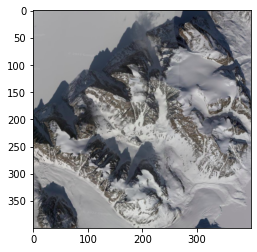

In [8]:
image_user = load_user_image(path_user_image)

4) Make prediction by using the trained model

In [9]:
result_user_image = model_reloaded.predict(image_user)

5) Print the top-5 prediction result

In [12]:
result_top5 = print_pred_result(result_user_image, classes_list)

Predictions                   Confidences
1 - snowberg                  - 60.63364 %
2 - mountain                  - 10.06222 %
3 - parkway                   - 7.48829 %
4 - commercial_area           - 7.38686 %
5 - harbor&port               - 6.76335 %


## 8.2- User Set Prediction

1. Define the user image path

In [30]:
path_user_set = path_root + "user_images"
path_user_set

'C:/Users/Deniz/CODEWORKS/remote-sensing-scene-classification-for-aerial-imaging/user_images'

2. Get the user dataset with filenames format

In [31]:
list_user_set = tf.data.Dataset.list_files(str(path_user_set+"/*/*"), shuffle=True)

# Examples
for ex in list_user_set.take(5):
    # Print modified-for-readiblity version of samples 
    print(ex.numpy().split(b"/")[-4:])

[b'C:\\Users\\Deniz\\CODEWORKS\\remote-sensing-scene-classification-for-aerial-imaging\\user_images\\harbor&port\\harbor&port_3.png']
[b'C:\\Users\\Deniz\\CODEWORKS\\remote-sensing-scene-classification-for-aerial-imaging\\user_images\\ground_track_field\\ground_track_field_3.png']
[b'C:\\Users\\Deniz\\CODEWORKS\\remote-sensing-scene-classification-for-aerial-imaging\\user_images\\airport\\airport_8.png']
[b'C:\\Users\\Deniz\\CODEWORKS\\remote-sensing-scene-classification-for-aerial-imaging\\user_images\\river\\river_4.png']
[b'C:\\Users\\Deniz\\CODEWORKS\\remote-sensing-scene-classification-for-aerial-imaging\\user_images\\tennis_court\\tennis_court_0.png']


3) Apply "convert_path_to_image"

In [32]:
image_user_set = list_user_set.map(convert_path_to_image)

4) Apply "one_hot_encoder"

In [33]:
image_user_set = image_user_set.map(lambda image,label: one_hot_encoder(image, label, classes_list))

5) Apply "resize_image"

In [34]:
def resize_image(image, label, size=[224,224]):
    # Resizing
    image = tf.image.resize(image, size)
    # Type casting to uint8 from float32
    image = tf.cast(image, dtype=tf.uint8) 

    # Return image and label
    return image, label

In [35]:
image_user_set = image_user_set.map(resize_image)

6) Apply "rescaler"

In [36]:
image_user_set = image_user_set.map(rescaler)

Mapping Test

(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(46,), dtype=tf.float32, name=None))
One-Hot label: tf.Tensor(
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(46,), dtype=float32)
One-Hot label: tf.Tensor(
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(46,), dtype=float32)
One-Hot label: tf.Tensor(
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], shape=(46,), dtype=float32)


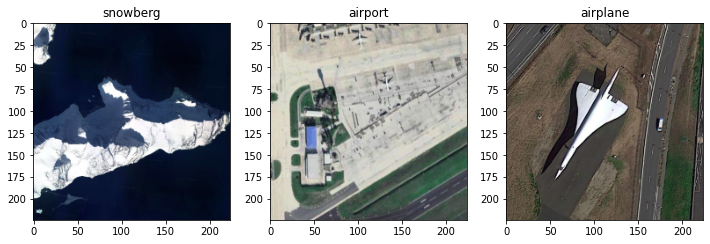

In [37]:
mapping_test(image_user_set, one_hot_label=True, classes=classes_list)

7. Apply mini-batching

In [38]:
image_user_set = image_user_set.batch(8)

In [39]:
image_user_set.element_spec

(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 46), dtype=tf.float32, name=None))

In [40]:
results_user_set = model_reloaded.evaluate(image_user_set)

NotFoundError: Graph execution error:

Detected at node 'model/initial_1_1_conv/Conv2D' defined at (most recent call last):
    File "C:\Users\AİLE\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\AİLE\AppData\Local\Programs\Python\Python39\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "c:\Users\Deniz\virenvs\dl_env\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "c:\Users\Deniz\virenvs\dl_env\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "c:\Users\Deniz\virenvs\dl_env\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "c:\Users\Deniz\virenvs\dl_env\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\AİLE\AppData\Local\Programs\Python\Python39\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\AİLE\AppData\Local\Programs\Python\Python39\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\AİLE\AppData\Local\Programs\Python\Python39\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\Deniz\virenvs\dl_env\lib\site-packages\ipykernel\kernelbase.py", line 504, in dispatch_queue
      await self.process_one()
    File "c:\Users\Deniz\virenvs\dl_env\lib\site-packages\ipykernel\kernelbase.py", line 493, in process_one
      await dispatch(*args)
    File "c:\Users\Deniz\virenvs\dl_env\lib\site-packages\ipykernel\kernelbase.py", line 400, in dispatch_shell
      await result
    File "c:\Users\Deniz\virenvs\dl_env\lib\site-packages\ipykernel\kernelbase.py", line 724, in execute_request
      reply_content = await reply_content
    File "c:\Users\Deniz\virenvs\dl_env\lib\site-packages\ipykernel\ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "c:\Users\Deniz\virenvs\dl_env\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\Deniz\virenvs\dl_env\lib\site-packages\IPython\core\interactiveshell.py", line 2880, in run_cell
      result = self._run_cell(
    File "c:\Users\Deniz\virenvs\dl_env\lib\site-packages\IPython\core\interactiveshell.py", line 2935, in _run_cell
      return runner(coro)
    File "c:\Users\Deniz\virenvs\dl_env\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\Deniz\virenvs\dl_env\lib\site-packages\IPython\core\interactiveshell.py", line 3134, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\Deniz\virenvs\dl_env\lib\site-packages\IPython\core\interactiveshell.py", line 3337, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\Deniz\virenvs\dl_env\lib\site-packages\IPython\core\interactiveshell.py", line 3397, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Deniz\AppData\Local\Temp\ipykernel_1688\2424667310.py", line 1, in <cell line: 1>
      results_user_set = model_reloaded.evaluate(image_user_set)
    File "c:\Users\Deniz\virenvs\dl_env\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Deniz\virenvs\dl_env\lib\site-packages\keras\engine\training.py", line 1716, in evaluate
      tmp_logs = self.test_function(iterator)
    File "c:\Users\Deniz\virenvs\dl_env\lib\site-packages\keras\engine\training.py", line 1525, in test_function
      return step_function(self, iterator)
    File "c:\Users\Deniz\virenvs\dl_env\lib\site-packages\keras\engine\training.py", line 1514, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Deniz\virenvs\dl_env\lib\site-packages\keras\engine\training.py", line 1507, in run_step
      outputs = model.test_step(data)
    File "c:\Users\Deniz\virenvs\dl_env\lib\site-packages\keras\engine\training.py", line 1471, in test_step
      y_pred = self(x, training=False)
    File "c:\Users\Deniz\virenvs\dl_env\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Deniz\virenvs\dl_env\lib\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Deniz\virenvs\dl_env\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Deniz\virenvs\dl_env\lib\site-packages\keras\engine\functional.py", line 451, in call
      return self._run_internal_graph(
    File "c:\Users\Deniz\virenvs\dl_env\lib\site-packages\keras\engine\functional.py", line 589, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\Deniz\virenvs\dl_env\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Deniz\virenvs\dl_env\lib\site-packages\keras\engine\base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Deniz\virenvs\dl_env\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Deniz\virenvs\dl_env\lib\site-packages\keras\layers\convolutional.py", line 248, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "c:\Users\Deniz\virenvs\dl_env\lib\site-packages\keras\layers\convolutional.py", line 233, in convolution_op
      return tf.nn.convolution(
Node: 'model/initial_1_1_conv/Conv2D'
No algorithm worked!  Error messages:
  Profiling failure on CUDNN engine 1#TC: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/stream_executor/cuda/cuda_dnn.cc(4141): 'cudnnConvolutionForward( cudnn.handle(), alpha, input_nd_.handle(), input_data.opaque(), filter_.handle(), filter_data.opaque(), conv_.handle(), ToConvForwardAlgo(algo), scratch_memory.opaque(), scratch_memory.size(), beta, output_nd_.handle(), output_data.opaque())'
  Profiling failure on CUDNN engine 1: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/stream_executor/cuda/cuda_dnn.cc(4141): 'cudnnConvolutionForward( cudnn.handle(), alpha, input_nd_.handle(), input_data.opaque(), filter_.handle(), filter_data.opaque(), conv_.handle(), ToConvForwardAlgo(algo), scratch_memory.opaque(), scratch_memory.size(), beta, output_nd_.handle(), output_data.opaque())'
  Profiling failure on CUDNN engine 0#TC: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/stream_executor/cuda/cuda_dnn.cc(4141): 'cudnnConvolutionForward( cudnn.handle(), alpha, input_nd_.handle(), input_data.opaque(), filter_.handle(), filter_data.opaque(), conv_.handle(), ToConvForwardAlgo(algo), scratch_memory.opaque(), scratch_memory.size(), beta, output_nd_.handle(), output_data.opaque())'
  Profiling failure on CUDNN engine 0: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/stream_executor/cuda/cuda_dnn.cc(4141): 'cudnnConvolutionForward( cudnn.handle(), alpha, input_nd_.handle(), input_data.opaque(), filter_.handle(), filter_data.opaque(), conv_.handle(), ToConvForwardAlgo(algo), scratch_memory.opaque(), scratch_memory.size(), beta, output_nd_.handle(), output_data.opaque())'
  Profiling failure on CUDNN engine 2#TC: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/stream_executor/cuda/cuda_dnn.cc(4141): 'cudnnConvolutionForward( cudnn.handle(), alpha, input_nd_.handle(), input_data.opaque(), filter_.handle(), filter_data.opaque(), conv_.handle(), ToConvForwardAlgo(algo), scratch_memory.opaque(), scratch_memory.size(), beta, output_nd_.handle(), output_data.opaque())'
  Profiling failure on CUDNN engine 2: UNKNOWN: CUDNN_STATUS_EXECUTION_FAILED
in tensorflow/stream_executor/cuda/cuda_dnn.cc(4141): 'cudnnConvolutionForward( cudnn.handle(), alpha, input_nd_.handle(), input_data.opaque(), filter_.handle(), filter_data.opaque(), conv_.handle(), ToConvForwardAlgo(algo), scratch_memory.opaque(), scratch_memory.size(), beta, output_nd_.handle(), output_data.opaque())'
  Profiling failure on CUDNN engine 5#TC: UNKNOWN: CUDNN_STATUS_INTERNAL_ERROR
in tensorflow/stream_executor/cuda/cuda_dnn.cc(4141): 'cudnnConvolutionForward( cudnn.handle(), alpha, input_nd_.handle(), input_data.opaque(), filter_.handle(), filter_data.opaque(), conv_.handle(), ToConvForwardAlgo(algo), scratch_memory.opaque(), scratch_memory.size(), beta, output_nd_.handle(), output_data.opaque())'
  Profiling failure on CUDNN engine 5: UNKNOWN: CUDNN_STATUS_INTERNAL_ERROR
in tensorflow/stream_executor/cuda/cuda_dnn.cc(4141): 'cudnnConvolutionForward( cudnn.handle(), alpha, input_nd_.handle(), input_data.opaque(), filter_.handle(), filter_data.opaque(), conv_.handle(), ToConvForwardAlgo(algo), scratch_memory.opaque(), scratch_memory.size(), beta, output_nd_.handle(), output_data.opaque())'
	 [[{{node model/initial_1_1_conv/Conv2D}}]] [Op:__inference_test_function_28091]

User Set Top-1 Score:

In [31]:
print("User set loss:", results_user_set[0])
print("User set accuracy:", results_user_set[1])

User set loss: 2.9683759212493896
User set accuracy: 0.4871794879436493
